[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/MaxMitre/Aplicaciones-Financieras/blob/main/Semana7/1_Manejo_de_portafolios_Markovitz.ipynb)

# Introducción

Trataremos de encontrar portafolios óptimos, utilizando como medidores la varianza de los retornos, así como el valor esperado de los retornos en un año (el valor que se espera ganar)

# Dependencias

In [ ]:
# !pip install yfinance -U plotly

In [ ]:
import yfinance as yf

import pandas as pd
import numpy as np

import cvxopt as opt

import plotly.express as px

# Datos


Los datos con los que trabajaremos son el precio de acciones de Google (GOOG), Apple (AAPL), IBM (IBM), Microsoft (MSFT) y ExxonMobil (XOM) del último año.

Para obtener los datos, usaremos [```yfinance```](https://github.com/ranaroussi/yfinance) y nos centraremos en el precio de cierre ajustado (Adj Close).

In [ ]:
data = yf.download(  # or pdr.get_data_yahoo(...
        # tickers list or string as well
        tickers = "GOOG AAPL IBM MSFT NFLX NVDA",

        # use "period" instead of start/end
        # valid periods: 1d,5d,1mo,3mo,6mo,1y,2y,5y,10y,ytd,max
        # (optional, default is '1mo')
        period = "1y",

        # fetch data by interval (including intraday if period < 60 days)
        # valid intervals: 1m,2m,5m,15m,30m,60m,90m,1h,1d,5d,1wk,1mo,3mo
        # (optional, default is '1d')
        interval = "1d",

        # group by ticker (to access via data['SPY'])
        # (optional, default is 'column')
        # group_by = 'ticker',
    ).loc[:, 'Adj Close']
data

[*********************100%%**********************]  6 of 6 completed


Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-05-22,173.279739,125.870003,122.295898,318.687042,363.010010,311.660065
2023-05-23,170.653702,123.290001,122.948135,312.812958,355.989990,306.781586
2023-05-24,170.932220,121.639999,120.550186,311.413910,364.850006,305.282104
2023-05-25,172.076157,124.349998,121.586113,323.390228,359.000000,379.678192
2023-05-26,174.503250,125.430000,123.629166,330.306122,378.880005,389.335083
...,...,...,...,...,...,...
2024-05-15,189.720001,173.880005,168.259995,423.079987,613.520020,946.299988
2024-05-16,189.839996,175.429993,168.970001,420.989990,610.520020,943.590027
2024-05-17,189.869995,177.289993,169.029999,420.209991,621.099976,924.789978


<Axes: xlabel='Date'>

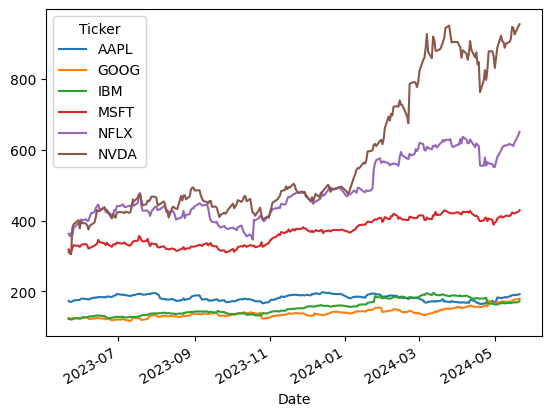

In [ ]:
data.plot()

In [ ]:
data.shift()

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-05-22,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-23,173.279739,125.870003,122.295898,318.687042,363.010010,311.660065
2023-05-24,170.653702,123.290001,122.948135,312.812958,355.989990,306.781586
2023-05-25,170.932220,121.639999,120.550186,311.413910,364.850006,305.282104
2023-05-26,172.076157,124.349998,121.586113,323.390228,359.000000,379.678192
...,...,...,...,...,...,...
2024-05-15,187.429993,171.929993,167.360001,415.809998,613.659973,913.559998
2024-05-16,189.720001,173.880005,168.259995,423.079987,613.520020,946.299988
2024-05-17,189.839996,175.429993,168.970001,420.989990,610.520020,943.590027


Obtenemos los retornos logarítmicos anualizados para cada activo.

In [ ]:
annual_returns = np.log(data / data.shift()) * 252 # Para anualizar los retornos
annual_returns

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Date,,,,,,
2023-05-22,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-23,-3.848270,-5.219005,1.340413,-4.688241,-4.921005,-3.975807
2023-05-24,0.410946,-3.395310,-4.963506,-1.129591,6.195096,-1.234741
2023-05-25,1.680851,5.552644,2.156266,9.509675,-4.073312,54.958113
2023-05-26,3.529567,2.179215,4.199259,5.332354,13.582083,6.329317
...,...,...,...,...,...,...
2024-05-15,3.060264,2.842071,1.351523,4.367875,-0.057479,8.873066
2024-05-16,0.159336,2.236406,1.061127,-1.247954,-1.235256,-0.722699
2024-05-17,0.039818,2.657771,0.089464,-0.467332,4.329606,-5.071530


In [ ]:
mean_returns = annual_returns.mean()
mean_returns

Ticker
AAPL    0.104825
GOOG    0.356563
IBM     0.350954
MSFT    0.298525
NFLX    0.585805
NVDA    1.123060
dtype: float64

In [ ]:
cov_returns = annual_returns.cov()
cov_returns

Ticker,AAPL,GOOG,IBM,MSFT,NFLX,NVDA
Ticker,,,,,,
AAPL,10.310026,5.672652,1.100656,5.095334,6.183442,7.852286
GOOG,5.672652,19.960626,1.730653,6.903789,6.454965,13.137154
IBM,1.100656,1.730653,10.632287,2.470084,1.718047,4.147492
MSFT,5.095334,6.903789,2.470084,11.263664,8.173054,13.315159
NFLX,6.183442,6.454965,1.718047,8.173054,31.213918,15.079874
NVDA,7.852286,13.137154,4.147492,13.315159,15.079874,57.620229


In [ ]:
mean_returns

Ticker
AAPL    0.104825
GOOG    0.356563
IBM     0.350954
MSFT    0.298525
NFLX    0.585805
NVDA    1.123060
dtype: float64

In [ ]:
omega = pd.Series([0.5, 0.1, 0.05, 0.15, 0.1, 0.1])*1000
omega

0    500.0
1    100.0
2     50.0
3    150.0
4    100.0
5    100.0
dtype: float64

In [ ]:
np.dot(1 + mean_returns, omega)

1321.2819826513787

# Markovitz

https://pyportfolioopt.readthedocs.io/en/latest/UserGuide.html

Si $w$ es el vector de pesos de las acciones con retornos esperados $\mu$, entonces el retorno del portafolio es igual al peso de cada acción multiplicado por su retorno, es decir, $w^T \mu$. El riesgo del portafolio en términos de la matriz de covarianzas $\Sigma$ esta dado por $\sigma^2 = w^T \Sigma w$.

Lo cual, un poco mas "desmenuzado", es lo escrito en los 2 siguientes cuadros de texto.



## Valor esperado de portafolio comparado con valor esperado de cada activo

Tengo 4 activos y un capital de $v_0$ pesos:
- cada activo tiene su retorno esperado $\mu_1, \, \mu_2, \, \mu_3, \, \mu_4 $
- a cada activo le invierto $w_1, \, w_2, \, w_3, \, w_4 $ ( son tales que $w_1 + w_2 + w_3 +  w_4 = v_0$)

Entonces:

$ \operatorname{E}(R_p) = \sum_i w_i \operatorname{E}(R_i) = \sum_i w_i \mu_i \quad $


## Volatilidad esperada de portafolio comparado con volatilidad de cada activo

- cada activo tiene una volatilida $\sigma_1, \, \sigma_2, \, \sigma_3, \, \sigma_4 $ respectivamente. Entonces la volatilidad del portafolio es:

$ \sigma_p^2 = \sum_i w_i^2 \sigma_{i}^2 + \sum_i \sum_{j \neq i} w_i w_j \sigma_i \sigma_j \rho_{ij} $,

donde $\sigma_i$ es la volatilidad de cada activo y $\rho_{ij}$ es el coeficiente de correlación de los retornos del activo $i$ con el activo $j$.

La razón de Sharpe es el retorno en exceso del portafolio por unidad de riesgo (volatilidad)

$$
SR = \frac{R_p-R_f}{\sigma}
$$

Con esto en mente, crearemos un cantidad $N$ de portafolios con pesos aleatorios y guardaremos tanto los pesos, como el retorno, la volatilidad y la razon de Sharpe para cada uno.

--------------------------------------------
*NOTA**: Los comentarios en los siguientes 2 bloques de código son para que al quitarlo veamos los portafolios PUROS (todo el capital a una sola acción)
--------------------------------------------
_____________________________________________



Si dejan los comentarios -> obtienen las 10,000 muestras

Si quitan los comentarios -> ¿que obtienen? ________________

In [ ]:
np.random.seed(1995)

N = 10000
#N = 6  ##

k = annual_returns.shape[1]

weights = np.zeros((N, k))
returns = np.zeros(N)
volatilities = np.zeros(N)
sharpe_ratios = np.zeros(N)

weights2 = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],[0,0,1,0,0,0],[0,0,0,1,0,0],[0,0,0,0,1,0],[0,0,0,0,0,1]])

weights.shape

(10000, 6)

In [ ]:
weights

array([[0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.]])

In [ ]:
w = np.random.random(6)
w /= np.sum(w)
w

array([0.23176348, 0.25672011, 0.05838959, 0.21149406, 0.23724876,
       0.00438401])

In [ ]:
for i in range(N):
    w = np.random.random(k)
    w /= np.sum(w)

    #w = weights2[i]  ##
    #weights[i, :] = weights2[i]  ##

    weights[i, :] = w

    returns[i] = np.dot(mean_returns, w)

    volatilities[i] = np.sqrt(np.dot(w.T, np.dot(cov_returns, w)))         ###        w.T @ cov_returns @ w

    sharpe_ratios[i] = returns[i] / volatilities[i]

In [ ]:
weights

array([[0.39789683, 0.09166851, 0.2506735 , 0.11003303, 0.10273552,
        0.0469926 ],
       [0.08622008, 0.15460911, 0.16012943, 0.18122302, 0.20754228,
        0.21027608],
       [0.01867013, 0.12536968, 0.03890514, 0.25378393, 0.28951477,
        0.27375635],
       ...,
       [0.24431589, 0.23067893, 0.24063098, 0.17955388, 0.00376932,
        0.101051  ],
       [0.1589712 , 0.05137859, 0.20937183, 0.22125611, 0.24760583,
        0.11141643],
       [0.12537544, 0.20632345, 0.18267669, 0.14410625, 0.28038533,
        0.06113284]])

In [ ]:
weights[7]

array([0.33190845, 0.00369118, 0.09624126, 0.09272891, 0.29168525,
       0.18374496])

In [ ]:
returns[7]

0.47479396259350404

In [ ]:
volatilities[7]

3.3649027172772343

Graficamos la volatilidad contra el retorno de cada portafolio generado y coloreamos en función de la razón de Sharpe. Los portafolios (casi) óptimos, serían aquellos que tienen el mayor retorno para cierto nivel de volatilidad, o dicho de otra manera, los que tienen la menor volatilidad para algún retorno especificado.

In [ ]:
# Portafolios puros
import matplotlib.pyplot as plt

px.scatter(x = volatilities, y = returns, color = sharpe_ratios,
           labels={
                     "x": "Volatilidad",
                     "y": "Retorno",
                     "color": "Razón de Sharpe"
                 }
           )
# plt.scatter(volatilities, returns, c = sharpe_ratios)

In [ ]:
import matplotlib.pyplot as plt

px.scatter(x = volatilities, y = returns, color = sharpe_ratios,
           labels={
                     "x": "Volatilidad",
                     "y": "Retorno",
                     "color": "Razón de Sharpe"
                 }
           )
# plt.scatter(volatilities, returns, c = sharpe_ratios)

> La optimización del portafolio se puede ver como un problema de optimización convexa y una solución puede encontrarse usando programación cuadrática. Si denotamos el retorno objetivo como $\mu^*$, el problema a resolver para el portafolio sólo con posiciones largas es:

\begin{align}
    \text{min}_w && w^T \Sigma w \\
    \text{s.a.} && w^t \mu \geq \mu^*  \\
    && w^T \mathbf{1} = 1 \\
    && w_i \geq 0
\end{align}

Para resolverlo, ocuparemos la función [```covxopt.solvers.qp```](https://cvxopt.org/userguide/coneprog.html#quadratic-programming). Esta requiere que el problema de optimización se encuentre en la forma general. A saber, la forma general de un problema de programación cuadrática es la siguiente:

\begin{align}
    \text{min}_x && \frac{1}{2}x^TPx + q^Tx \\
    \text{s.a.} && Gx \preceq h \\
    && Ax = b
\end{align}

In [ ]:
mu_star = 0.5

In [ ]:
G = opt.matrix(-np.concatenate([mean_returns.to_numpy().reshape(1, k),np.eye(k)]), tc = 'd')
h = opt.matrix(np.concatenate([np.array([-mu_star]).reshape((1, 1)), np.zeros((k, 1))]), tc = 'd')
q = opt.matrix(0.0, (k, 1))
A = opt.matrix(1.0, (1, k))
b = opt.matrix(1.0)
P = opt.matrix(2 * cov_returns.to_numpy(), tc = 'd')

In [ ]:
results = opt.solvers.qp(P, q, G, h, A, b)
results

     pcost       dcost       gap    pres   dres
 0:  5.1141e+00  4.4914e+00  1e+01  3e+00  5e+00
 1:  5.1615e+00  4.9447e+00  2e+00  7e-01  1e+00
 2:  1.1094e+01  7.3459e+00  8e+00  3e-01  4e-01
 3:  8.7813e+00  8.1881e+00  6e-01  1e-16  2e-14
 4:  8.3863e+00  8.3565e+00  3e-02  2e-16  8e-15
 5:  8.3630e+00  8.3627e+00  3e-04  1e-16  4e-15
 6:  8.3628e+00  8.3628e+00  3e-06  2e-16  1e-15
Optimal solution found.


{'x': <6x1 matrix, tc='d'>,
 'y': <1x1 matrix, tc='d'>,
 's': <7x1 matrix, tc='d'>,
 'z': <7x1 matrix, tc='d'>,
 'status': 'optimal',
 'gap': 3.0178076986190323e-06,
 'relative gap': 3.6086163204593895e-07,
 'primal objective': 8.362786507726778,
 'dual objective': 8.36278348991908,
 'primal infeasibility': 2.2388688230491736e-16,
 'dual infeasibility': 1.3803799860169535e-15,
 'primal slack': 1.015436842754076e-07,
 'dual slack': 2.1238671255983237e-07,
 'iterations': 6}

Los pesos del portafolio óptimo los obtenemos de la llave ```x```

In [ ]:
# impresion bonita de los numeros decimales
np.set_printoptions(suppress=True)

In [ ]:
w = np.asarray(results['x']).reshape((-1))
w

array([0.01199571, 0.11976473, 0.50698453, 0.05186462, 0.15790662,
       0.1514838 ])

In [ ]:
mean_returns

Ticker
AAPL    0.104825
GOOG    0.356563
IBM     0.350954
MSFT    0.298525
NFLX    0.585805
NVDA    1.123060
dtype: float64

In [ ]:
# PORTAFOLIO ARRIESGADO, 0.5
np.dot(mean_returns, w)

0.5000001015436842

La volatilidad de ```primal objective```

In [ ]:
np.sqrt(results['primal objective'])

2.8918482857381673

In [ ]:
# PORTAFOLIO ARRIESGADO, mu_estrella es 0.1
np.dot(mean_returns, w)

0.5000001015436842

In [ ]:
np.sqrt(results['primal objective'])

2.8918482857381673

Si variamos los retornos objetivos, podemos obtener la **Frontera Eficiente**, que esta constituida de los portafolios óptimos para distintos niveles del retorno.

In [ ]:
mu_stars = np.linspace(.0, .6, 51)
mu_stars

array([0.   , 0.012, 0.024, 0.036, 0.048, 0.06 , 0.072, 0.084, 0.096,
       0.108, 0.12 , 0.132, 0.144, 0.156, 0.168, 0.18 , 0.192, 0.204,
       0.216, 0.228, 0.24 , 0.252, 0.264, 0.276, 0.288, 0.3  , 0.312,
       0.324, 0.336, 0.348, 0.36 , 0.372, 0.384, 0.396, 0.408, 0.42 ,
       0.432, 0.444, 0.456, 0.468, 0.48 , 0.492, 0.504, 0.516, 0.528,
       0.54 , 0.552, 0.564, 0.576, 0.588, 0.6  ])

In [ ]:
G = opt.matrix(-np.concatenate([mean_returns.to_numpy().reshape(1, k),np.eye(k)]), tc = 'd')
q = opt.matrix(0.0, (k, 1))
A = opt.matrix(1.0, (1, k))
b = opt.matrix(1.0)
P = opt.matrix(2 * cov_returns.to_numpy(), tc = 'd')

mu_stars = np.linspace(.0, .6, 51)    #####################

ws = np.zeros((len(mu_stars), k))
mus = np.zeros(len(mu_stars))
sigmas = np.zeros(len(mu_stars))

for i, mu_star in enumerate(mu_stars):
    try:
        h = opt.matrix(np.concatenate([np.array([-mu_star]).reshape((1, 1)), np.zeros((k, 1))]), tc = 'd')
        results = opt.solvers.qp(P, q, G, h, A, b)

        w = np.asarray(results['x']).reshape((-1))
        ws[i, :] = w
        mus[i] = np.dot(mean_returns, w)
        sigmas[i] = np.sqrt(results['primal objective'])
    except:
        print('domain error')

     pcost       dcost       gap    pres   dres
 0:  5.1118e+00  3.7788e+00  1e+01  3e+00  5e+00
 1:  5.1294e+00  4.2490e+00  1e+00  2e-01  3e-01
 2:  5.4667e+00  4.9880e+00  5e-01  2e-16  5e-15
 3:  5.2944e+00  5.2560e+00  4e-02  2e-16  7e-15
 4:  5.2691e+00  5.2684e+00  7e-04  1e-16  3e-15
 5:  5.2686e+00  5.2686e+00  7e-06  1e-16  3e-15
 6:  5.2686e+00  5.2686e+00  7e-08  1e-16  4e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.1119e+00  3.7901e+00  1e+01  3e+00  5e+00
 1:  5.1298e+00  4.2537e+00  1e+00  2e-01  3e-01
 2:  5.4657e+00  4.9898e+00  5e-01  1e-16  2e-15
 3:  5.2942e+00  5.2561e+00  4e-02  1e-16  4e-15
 4:  5.2691e+00  5.2684e+00  6e-04  2e-16  3e-15
 5:  5.2686e+00  5.2686e+00  6e-06  1e-16  3e-15
 6:  5.2686e+00  5.2686e+00  6e-08  1e-16  5e-15
Optimal solution found.
     pcost       dcost       gap    pres   dres
 0:  5.1119e+00  3.8017e+00  1e+01  3e+00  5e+00
 1:  5.1302e+00  4.2587e+00  1e+00  2e-01  3e-01
 2:  5.4647e+00  4.9916e

Finalmente, podemos graficar la frontera eficiente. Se puede observar que, pese a que las simulaciones nos dieron portafolios a la frontera, no eran realmente óptimos.

In [ ]:
mus[-3:]

array([0.57600001, 0.58800002, 0.60000002])

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_traces(
    [
        go.Scatter(
            x = volatilities, y = returns,
            marker = dict(
                color = sharpe_ratios,
                colorbar = dict(title="Razón de Sharpe")
            ),
            mode = 'markers',
            showlegend = False
        ),
        go.Scatter(
            x = sigmas, y = mus,
            mode = 'lines + markers',
            showlegend = False
        )
])

fig.update_layout(
    xaxis_title = 'Volatilidad',
    yaxis_title = 'Retorno'
)



Notas

1. Se están usando los retornos sin considerar la tasa libre de riesgo.

Ejercicios

1. Encontrar y graficar el portafolio óptimo de acuerdo a la razón de Sharpee
2. Agregar los puntos de los portafolios que contienen únicamente un activo
3. Encontrar el portafolio con la menor volatilidad
4. Restar la tasa libre de riesgo a los retornos

# Mean-Variance Choice

El portafolio óptimo también se podría obtener maximizando, respecto a $w$,

$$
U(\mu, \Sigma; w) = w^T\mu - \frac{\delta}{2}w^T\Sigma w
$$

donde $\delta > 0$ es el parámetro de aversión al riesgo. La condición de primer orden para maximizarla es

$$
\mu = \delta \Sigma w
$$

lo que implica el siguiente diseño para un portafolio con riesgo:

$$
w = \left( \delta \Sigma \right)^{-1} \mu
$$

Es un sistema de ecuaciones lineales que podemos resolver con [```np.linalg.solve```](https://numpy.org/doc/stable/reference/generated/numpy.linalg.solve.html).

In [ ]:
delta = .2

np.linalg.solve(delta * cov_returns,  mean_returns)

array([-0.06629797,  0.03347792,  0.13145856, -0.0246617 ,  0.06104751,
        0.07911545])

In [ ]:
data.columns

Index(['AAPL', 'GOOG', 'IBM', 'MSFT', 'NFLX', 'NVDA'], dtype='object', name='Ticker')

# Ligas interesantes

1. https://python-advanced.quantecon.org/black_litterman.html